<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model 
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

We'll use PyTorch Lightning for training here, but note that this is optional, you can of course also just train in native PyTorch or use 🤗 Accelerate, or the 🤗 Trainer.

In [4]:
from shared import CONFIGS_DIR
from hydra import compose, initialize_config_dir
tests_config_dir = CONFIGS_DIR / "lmv3"
with initialize_config_dir(config_dir=str(tests_config_dir), job_name="test", version_base="1.1"):
    config =  compose(config_name="config")

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from dataset.utils import get_dataset

dataset = get_dataset(config)
dataset.shuffle()

Using the latest cached version of the module from /home/222963/.cache/huggingface/modules/datasets_modules/datasets/artpods56--EcclesialSchematisms/a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b (last modified on Mon Jun 23 22:12:24 2025) since it couldn't be found locally at artpods56/EcclesialSchematisms, or remotely on the Hugging Face Hub.
Generating train split: 100%|██████████| 482/482 [00:56<00:00,  8.57 examples/s]


Dataset({
    features: ['image_pil', 'image', 'width', 'height', 'words', 'bboxes', 'labels', 'conf'],
    num_rows: 482
})

In [7]:
from dataset.filters import filter_schematisms
dataset = dataset.filter(filter_schematisms("wloclawek_1872, wloclawek_1873"))

Filter: 100%|██████████| 482/482 [00:14<00:00, 34.40 examples/s]


In [5]:
dataset

Dataset({
    features: ['image_pil', 'image', 'width', 'height', 'words', 'bboxes', 'labels', 'conf'],
    num_rows: 177
})

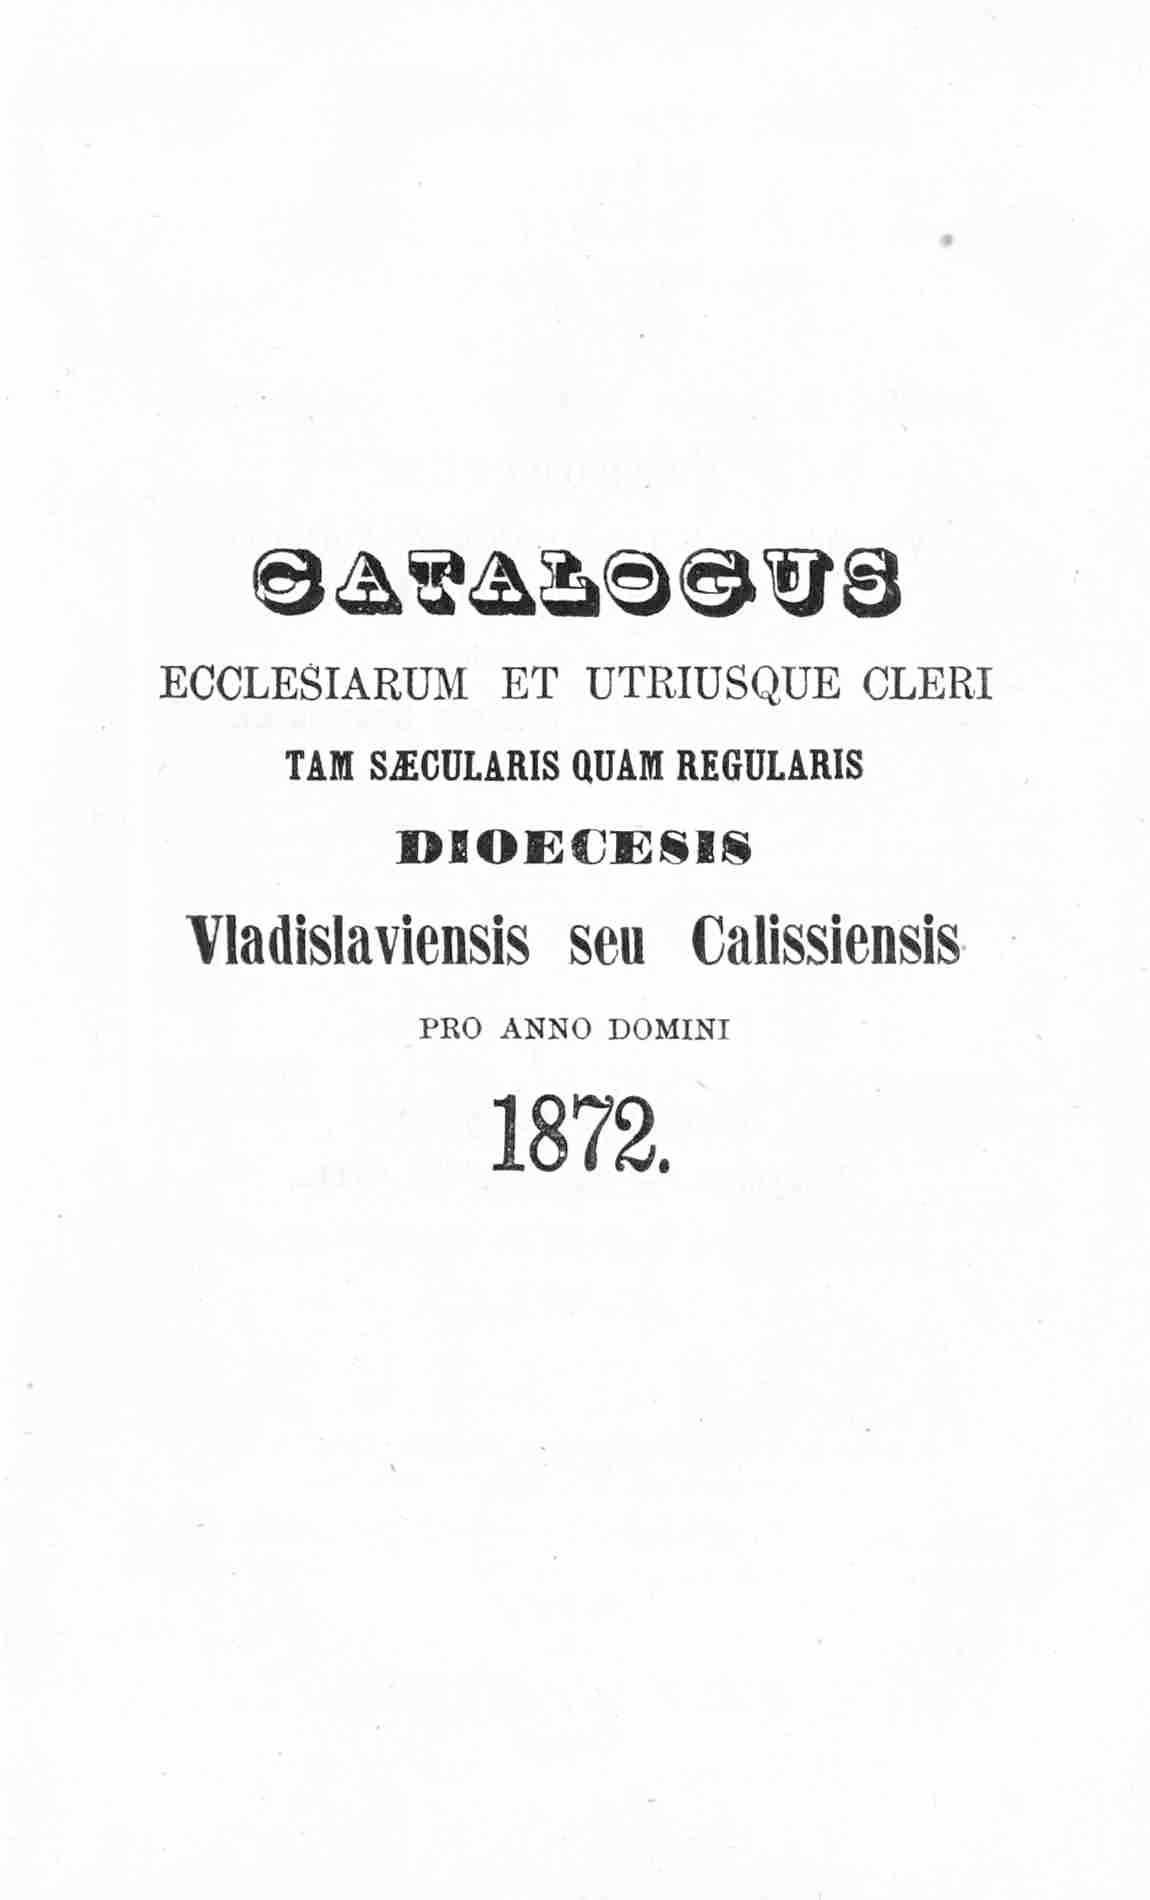

In [6]:
dataset[0]["image_pil"]

In [7]:
from pathlib import Path
import json, itertools, re

json_dir   = Path("train_json")          # folder that holds all 400 GT files
task_token = "<s_parish-register>"       # 1️⃣  your task-prompt token

def collect_keys(obj, keys):
    "Recursively gather every dict key that will need a tag"
    if isinstance(obj, dict):
        for k, v in obj.items():
            keys.add(k)
            collect_keys(v, keys)
    elif isinstance(obj, list):
        for item in obj:
            collect_keys(item, keys)

keys = set()




In [8]:
from dataset.utils import build_page_json

for i, batch in enumerate(dataset):

    json_page = build_page_json(batch["words"],batch["bboxes"],batch["labels"])
    collect_keys(json_page, keys)
print("keys found:", keys)

keys found: {'deanery', 'entries', 'page_number', 'parish', 'dedication', 'building_material'}


Let's take a look at the first training example:

In [9]:
# 2️⃣  produce <s_key>  and </s_key> for every key
special_tokens = [task_token]                       # start-of-prompt
for k in sorted(keys):
    special_tokens += [f"<s_{k}>", f"</s_{k}>"]


print("special tokens:", special_tokens)

special tokens: ['<s_parish-register>', '<s_building_material>', '</s_building_material>', '<s_deanery>', '</s_deanery>', '<s_dedication>', '</s_dedication>', '<s_entries>', '</s_entries>', '<s_page_number>', '</s_page_number>', '<s_parish>', '</s_parish>']


In [13]:
%load_ext autoreload
%autoreload 2


from datasets import load_dataset
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
    VisionEncoderDecoderConfig
)
from torch.utils.data import Dataset
import torch, itertools, re, random
from typing import Any, List
from donut.utils import DonutDataset

image_size = [1280, 960]
max_length = 768
base_ckpt = "naver-clova-ix/donut-base-finetuned-cord-v2"
# --- config
config = VisionEncoderDecoderConfig.from_pretrained(base_ckpt)
config.encoder.image_size = image_size # (height, width)
config.decoder.max_length = max_length


# ─────────────────── 2.  Load raw HF splits ───────────────────────────────────────
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
# ─────────────────── 3.  Model & Processor ────────────────────────────────────────

processor = DonutProcessor.from_pretrained(base_ckpt)
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False
# num_new = processor.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens + [task_token]})

model     = VisionEncoderDecoderModel.from_pretrained(base_ckpt, config=config)


start_id    = processor.tokenizer.convert_tokens_to_ids(task_token)

model.config.decoder_start_token_id = start_id
model.config.eos_token_id           = processor.tokenizer.eos_token_id
model.config.pad_token_id           = processor.tokenizer.pad_token_id
model.to(device)
# ─────────────────── 4.  Wrap with DonutDataset ───────────────────────────────────

train_ds = DonutDataset(train_test_split['train'], processor, model, max_length=max_length, split="train",task_start_token=task_token)
train_ds.add_tokens(special_tokens + [task_token])  # add new special tokens to the dataset

val_ds   = DonutDataset(train_test_split['test'], processor, model, max_length=max_length, split="train",task_start_token=task_token)

model.tie_weights() 

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


NameError: name 'special_tokens' is not defined

In [11]:
tokens = processor.tokenizer.encode("ł", add_special_tokens=True)
print(tokens)
for t in tokens:
    print(processor.tokenizer.decode(t))

[0, 42990, 16523, 2]
<s>

ł
</s>


In [12]:
dataset[0]

{'image_pil': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1150x1900>,
 'image': 'wloclawek_1872_0001.jpg',
 'width': 1150,
 'height': 1900,
 'words': ['ZQAWAŁOGYJ',
  'ECCLESIARUM',
  'ET',
  'UTRIUSQUE',
  'CLERI',
  'TAM',
  'SACULARIS',
  'QUAM',
  'REGULARIS',
  'ОФК',
  'Vladislaviensis',
  'seu',
  'Calissiensis',
  'PRO',
  'ANNO',
  'DOMINT',
  '18/2.'],
 'bboxes': [[220, 288, 783, 325],
  [139, 349, 406, 368],
  [436, 350, 485, 367],
  [509, 349, 730, 371],
  [751, 350, 862, 368],
  [247, 394, 307, 411],
  [321, 394, 486, 411],
  [498, 394, 577, 412],
  [588, 394, 750, 411],
  [344, 436, 653, 455],
  [161, 481, 460, 507],
  [495, 486, 560, 507],
  [601, 481, 834, 507],
  [365, 535, 418, 546],
  [434, 535, 513, 546],
  [529, 535, 633, 547],
  [428, 575, 581, 617]],
 'labels': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'conf': [9.0,
  96.0,
  93.0,
  92.0,
  96.0,
  93.0,
  62.0,
  92.0,
  92.0

In [13]:
for id in train_ds[0]["labels"]:
    
    if id == -100:
        continue
    print(processor.tokenizer.decode(id), end="")

Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.


<s_page_number>86</s_page_number><s_entries><s_parish>Kwiatkowice,</s_parish><s_dedication>Assump.BM,</s_dedication><s_building_material>mur.</s_building_material><sep/><s_parish>Marzenin,</s_parish><s_dedication>Nativ.</s_dedication><s_building_material>lig.</s_building_material><sep/><s_parish>Mikolajewice,</s_parish><s_dedication>5.Laur.<unk>.Mathaeus</s_dedication><s_building_material></s_building_material><sep/><s_parish>Pabijanice,</s_parish><s_dedication>Ap.</s_dedication><s_building_material>mur.</s_building_material></s_entries><s_deanery></s_deanery>

In [8]:
import evaluate, numpy as np, itertools, collections, json, re

cer_metric   = evaluate.load("cer")
wer_metric   = evaluate.load("wer")        # word-error-rate
bleu_metric  = evaluate.load("bleu")       # optional, sentence BLEU
exact_metric = evaluate.load("exact_match")

# ---------- helpers for KV-specific metrics -----------------
def norm_kv(node):
    "Lower-case keys & strip whitespace, works for both dict *and* list."
    if isinstance(node, dict):
        return {k.lower().strip(): str(v).strip() for k, v in node.items()}
    elif isinstance(node, list):
        return [norm_kv(x) for x in node]           # recursively normalise
    else:                                           # leaf node (str / None / int)
        return str(node).strip()
def micro_f1(pred, gt):
    """flat micro-F1 over all key–value pairs; works for nested lists too"""
    def flatten(obj):
        if isinstance(obj, dict):
            return list(obj.items())
        if isinstance(obj, list):
            return list(itertools.chain.from_iterable(flatten(x) for x in obj))
        return []                            # non-dict/ non-list

    p_set = set(flatten(norm_kv(pred)))
    g_set = set(flatten(norm_kv(gt)))
    tp = len(p_set & g_set); fp = len(p_set - g_set); fn = len(g_set - p_set)
    return (2*tp) / (2*tp + fp + fn) if tp else 0.0

prompt = "<s_parish-register>"              # or whatever you picked

def strip_prompt(s):
    return s[len(prompt):].lstrip() if s.startswith(prompt) else s
# ------------------------------------------------------------


def compute_metrics(eval_pred):
    preds, labels = eval_pred               # ① raw ID tensors / arrays

    # ② replace -100 (ignore_index) with pad so the tokenizer can decode
    preds  = np.where(preds  == -100, processor.tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, processor.tokenizer.pad_token_id, labels)

    # ③ decode into strings
    pred_str  = processor.batch_decode(preds,  skip_special_tokens=False)
    label_str = processor.batch_decode(labels, skip_special_tokens=False)

    # --- TEXT-LEVEL METRICS ---------------------------------
    # strip prompt + EOS/PAD, then drop all remaining <s_xxx> tags
    clean_pred  = [re.sub(r"<.*?>", " ", strip_prompt(s)).strip() for s in pred_str]
    clean_label = [re.sub(r"<.*?>", " ", strip_prompt(s)).strip() for s in label_str]

    cer  = cer_metric.compute(predictions=clean_pred,  references=clean_label)
    wer  = wer_metric.compute(predictions=clean_pred,  references=clean_label)
    bleu = bleu_metric.compute(predictions=clean_pred, references=clean_label)["bleu"]

    # --- STRUCTURE-AWARE METRICS ---------------------------
    pred_json  = [processor.token2json(strip_prompt(s)) for s in pred_str]
    label_json = [processor.token2json(strip_prompt(s)) for s in label_str]

    # Exact-match on the whole JSON string (after sorting keys)
    def jnorm(d):            # stable serialisation for exact-match
        return json.dumps(d, ensure_ascii=False, sort_keys=True)

    exact = exact_metric.compute(
                predictions=[jnorm(x) for x in pred_json],
                references=[jnorm(y) for y in label_json])["exact_match"]

    # Micro-F1 over key–value pairs
    f1 = np.mean([micro_f1(p, g) for p, g in zip(pred_json, label_json)])

    return {
        "cer":  cer,
        "wer":  wer,
        "bleu": bleu,
        "exact_match": exact,
        "micro_f1":   f1,
    }


In [15]:

# ─────────────────── 5.  Simple exact-match metric ────────────────────────────────
# import evaluate
# cer = evaluate.load("cer")  # or any string-metric you prefer
# import numpy as np           # or torch, works the same

# def compute_metrics(eval_pred):
#     preds, labels = eval_pred

#     # 1️⃣  sanitise everything that the tokenizer can’t handle
#     preds  = np.where(preds  == -100, processor.tokenizer.pad_token_id, preds)
#     labels = np.where(labels == -100, processor.tokenizer.pad_token_id, labels)

#     # 2️⃣  decode and compute any text metrics you like
#     pred_txt  = processor.batch_decode(preds,  skip_special_tokens=True)
#     label_txt = processor.batch_decode(labels, skip_special_tokens=True)

#     return {"cer": cer.compute(predictions=pred_txt, references=label_txt)}

# ─────────────────── 6.  Training setup ───────────────────────────────────────────
args = Seq2SeqTrainingArguments(
    output_dir="./donut-kv",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=75,
    learning_rate=1e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="wandb",
    gradient_accumulation_steps=4,
    eval_accumulation_steps=4,
    optim="adamw_torch",
    warmup_steps=400,
    fp16=True,
    predict_with_generate=True,
    generation_max_length=768,             # keep inside decoder limit
    generation_num_beams=1,  
)

trainer = Seq2SeqTrainer(
    model           = model,
    args            = args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    data_collator   = default_data_collator,   # works because items are dicts
    compute_metrics = compute_metrics,
)


In [16]:
# trainer.train()

In [17]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [14]:
import torch
from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel
image_size = [1280, 960] # (height, width)
max_length = 768
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
config.decoder.max_length = max_length
trained_ckpt = "/home/222963/AI_Osrodek/src/donut-kv/checkpoint-360"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = VisionEncoderDecoderModel.from_pretrained(trained_ckpt)
model.to(device)
model.eval()

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [15]:
def donut_predict(img, prompt):
    pixel = processor(img.convert("RGB"), return_tensors="pt").pixel_values.to(device)
    dec_in  = processor.tokenizer(prompt, add_special_tokens=False,
                                  return_tensors="pt").input_ids.to(device)

    # out = model.generate(
    #     pixel, decoder_input_ids=dec_in,
    #     max_length=model.decoder.config.max_position_embeddings,
    #     pad_token_id=processor.tokenizer.pad_token_id,
    #     eos_token_id=processor.tokenizer.eos_token_id,
    #     bad_words_ids=[[processor.tokenizer.unk_token_id]],
    #     num_beams=1, return_dict_in_generate=True,
    # )
    out = model.generate(
            pixel,
            decoder_input_ids=dec_in,
            max_length=model.decoder.config.max_position_embeddings,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    seq = processor.batch_decode(out.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()      # drop first task token
    return processor.token2json(seq)                      # dict ✔


In [16]:
import evaluate, itertools, collections, numpy as np
from dataset.utils import build_page_json
from tqdm import tqdm
import json

exact_match = evaluate.load("exact_match")      # 🤗 Evaluate hub :contentReference[oaicite:6]{index=6}
cer_metric  = evaluate.load("cer")


def micro_f1(pred, gt):
    pred_flat = list(norm_kv(pred).items())
    gt_flat   = list(norm_kv(gt).items())
    pred_set  = set(pred_flat);  gt_set = set(gt_flat)
    tp = len(pred_set & gt_set)
    fp = len(pred_set - gt_set)
    fn = len(gt_set - pred_set)
    return (2*tp) / (2*tp + fp + fn) if tp else 0.0

def normalise(d):
    # make sure key order is stable
    if isinstance(d, str):
        json_object = json.loads(d)
        return json.dumps(json_object, ensure_ascii=False, sort_keys=True)
    elif isinstance(d, dict):
        return json.dumps(d, ensure_ascii=False, sort_keys=True)



accs, f1s, cers = [], [], []

for sample in tqdm(dataset):
    pred = donut_predict(sample["image_pil"], task_token)
    gt   = build_page_json(sample["words"], sample["bboxes"], sample["labels"])

    # ---- metrics ----------------------------------------------------------
    pred_str = normalise(pred)   # your `processor.token2json(...)`
    ref_str  = normalise(gt) 

    score = exact_match.compute(
                predictions=[pred_str],
                references=[ref_str]
                 )["exact_match"]



    # CER only on *values*
    pred_vals = " ".join(norm_kv(pred))
    gt_vals   = " ".join(norm_kv(gt))
    cers.append(cer_metric.compute(predictions=[pred_vals], references=[gt_vals]))
    print("------")
    print("Sample ID:", sample["image"])
    print("Grount truth:")
    print(gt)
    print("Prediction:")
    print(pred)
    print("Exact match:", score)
    print(cers[-1])
    
scores = {
    "exact_match": np.mean(accs),
    "cer":         np.mean(cers),
}
print(scores, f"evaluated over {len(dataset)} samples")



  1%|          | 1/177 [00:02<06:10,  2.11s/it]

------
Sample ID: wloclawek_1872_0001.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': '서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서비스서

  1%|          | 2/177 [00:04<05:52,  2.01s/it]

------
Sample ID: wloclawek_1872_0002.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': '侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵害侵

  2%|▏         | 3/177 [00:06<05:52,  2.02s/it]

------
Sample ID: wloclawek_1872_0003.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': 'أفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلامأفلام 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영화 영

  2%|▏         | 4/177 [00:08<05:53,  2.04s/it]

------
Sample ID: wloclawek_1872_0004.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': '..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'}
Exact match: 0.0
0.8148148148148148


  3%|▎         | 5/177 [00:10<05:48,  2.03s/it]

------
Sample ID: wloclawek_1872_0005.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': 'ęęęęęęęęęęęęęęęęęęę.<sep/> Apisi,......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'}
Exact match: 0.0
0.8148148148148148


  3%|▎         | 6/177 [00:12<05:42,  2.00s/it]

------
Sample ID: wloclawek_1872_0006.jpg
Grount truth:
{'page_number': '6', 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': '.<sep/> Conis,i,i,i,i,i,i,i,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'}
Exact match: 0.0
0.8148148148148148


  4%|▍         | 7/177 [00:14<05:44,  2.03s/it]

------
Sample ID: wloclawek_1872_0007.jpg
Grount truth:
{'page_number': None, 'deanery': None, 'entries': []}
Prediction:
{'text_sequence': 'canacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacanacan

  4%|▍         | 7/177 [00:15<06:18,  2.23s/it]


KeyboardInterrupt: 

In [ ]:
processor.tokenizer("ł")["input_ids"]

[0, 42990, 16523, 2]